## Spark Setup

In [2]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# START INIT ENVIRONMENT
!ls /content/drive/MyDrive/Project_2024/DES_Project/Spark/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq >/dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

/content/drive/MyDrive/Project_2024/DES_Project/Spark/spark-3.5.2-bin-hadoop3.tgz


In [4]:
# START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Flight Delay Prediction")\
         .getOrCreate()

In [5]:
# BASE IMPORTS

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import time
from pyspark.sql.functions import count as spark_count
from pyspark.sql import functions as F

Understanding Data

In [7]:
# Load the dataset
flights = spark.read.csv("/content/drive/My Drive/Project_2024/DES_Project/Flight_Dataset_July24.csv", header=True, inferSchema=True)

In [8]:
# Display the first few rows of the dataset
flights.show(10)

+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+---------------------------------------+----------------------------------------------+-------------------------------------------------+--------------------------------------------------+------------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+-------------------+---------+-------------+--------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+----------------+--------

In [9]:
# Selecting relevant columns

flights2 = flights.select(
    "DayofMonth", "DayOfWeek", "Operating_Airline ", "OriginCityName", "DestCityName",
    "CRSDepTime", "DepTime", "DepDelay", "DepDelayMinutes", "WheelsOff", "WheelsOn",
    "CRSArrTime", "ArrTime", "ArrDelay", "ArrDelayMinutes", "Cancelled", "Diverted",
    "ActualElapsedTime", "Distance", "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay"
)

flights2.show(5)

+----------+---------+------------------+--------------------+-------------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|DayofMonth|DayOfWeek|Operating_Airline |      OriginCityName|       DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|WheelsOff|WheelsOn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----------+---------+------------------+--------------------+-------------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|        29|        1|                NK|Dallas/Fort Worth...|Fort Lauderdale, FL|      102

In [10]:
# Checking Data Types of columns

flights2.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- WeatherDelay: double (nullable = true)
 |-- NASDelay: double (nullable = true)
 |-- SecurityDelay: double (nullable = true)
 |--

In [11]:
# Check for duplicate values
total_rows = flights2.count()
print(f"Total number of rows: {total_rows}")

distinct_rows = flights2.distinct().count()
print(f"Number of distinct rows: {distinct_rows}")

duplicate_rows = total_rows - distinct_rows
print(f"Number of duplicate rows: {duplicate_rows}")

Total number of rows: 676807
Number of distinct rows: 676807
Number of duplicate rows: 0


In [12]:
# To view null values % in dataframe

null_percentages = flights2.select([
    ((count(when(col(c).isNull() | isnan(c), c)) / count(lit(1))) * 100).alias(c) for c in flights2.columns
])

null_percentages.show()

+----------+---------+------------------+--------------+------------+----------+------------------+-----------------+-----------------+------------------+------------------+----------+------------------+-----------------+-----------------+---------+--------+-----------------+--------+-----------------+-----------------+-----------------+-----------------+-----------------+
|DayofMonth|DayOfWeek|Operating_Airline |OriginCityName|DestCityName|CRSDepTime|           DepTime|         DepDelay|  DepDelayMinutes|         WheelsOff|          WheelsOn|CRSArrTime|           ArrTime|         ArrDelay|  ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|     CarrierDelay|     WeatherDelay|         NASDelay|    SecurityDelay|LateAircraftDelay|
+----------+---------+------------------+--------------+------------+----------+------------------+-----------------+-----------------+------------------+------------------+----------+------------------+-----------------+-----------------+---------

In [13]:
# Cancelled / Diverted Flights

flights2.groupBy("Cancelled").agg(spark_count("*").alias("Count")).show()

flights2.groupBy("Diverted").agg(spark_count("*").alias("Count")).show()


+---------+------+
|Cancelled| Count|
+---------+------+
|      0.0|657233|
|      1.0| 19574|
+---------+------+

+--------+------+
|Diverted| Count|
+--------+------+
|     0.0|674375|
|     1.0|  2432|
+--------+------+



Data Preprocessing and Feature Engineering

In [14]:
# Handling Null Values

# List of columns to check for null values
columns_to_check = [
    "DepTime", "DepDelay", "DepDelayMinutes", "WheelsOff", "WheelsOn",
    "ArrTime", "ArrDelay", "ArrDelayMinutes", "ActualElapsedTime"
]

# Drop rows with null values in the specified columns
flights_cleaned = flights2.dropna(subset=columns_to_check)

#Columns to impute with 0
columns_to_impute = [
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
]

# missing values to 0
flights_cleaned = flights_cleaned.fillna(0, subset=columns_to_impute)


# percentage of null values
null_percentages = flights_cleaned.select([
    ((count(when(col(c).isNull() | isnan(c), c)) / count(lit(1))) * 100).alias(c) for c in flights_cleaned.columns
])

null_percentages.show()

+----------+---------+------------------+--------------+------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|DayofMonth|DayOfWeek|Operating_Airline |OriginCityName|DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|WheelsOff|WheelsOn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----------+---------+------------------+--------------+------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|       0.0|      0.0|               0.0|           0.0|         0.0|       0.0|    0.0|     0.0|            0.0|      0.0|     0.

In [15]:
# Mapping Airlines against Airline Codes

airline_dict = {
    "UA": "United Airlines",
    "NK": "Spirit Airlines",
    "AA": "American Airlines",
    "OO": "SkyWest Airlines",
    "YV": "Mesa Airlines",
    "C5": "CommutAir",
    "OH": "PSA Airlines",
    "G7": "GoJet Airlines",
    "9E": "Endeavor Air",
    "B6": "JetBlue Airways",
    "PT": "Piedmont Airlines",
    "DL": "Delta Air Lines",
    "F9": "Frontier Airlines",
    "MQ": "Envoy Air",
    "HA": "Hawaiian Airlines",
    "G4": "Allegiant Air",
    "ZW": "Air Wisconsin",
    "YX": "Republic Airways",
    "AS": "Alaska Airlines",
    "QX": "Horizon Air",
    "WN": "Southwest Airlines",
    "EV": "ExpressJet Airlines",
    "VX": "Virgin America"
}

airline_df = spark.createDataFrame(airline_dict.items(), ["Operating_Airline ", "Operating_Airline_Name"])
broadcast_airline_df = broadcast(airline_df)

# Join the original DataFrame and broadcasted DataFrame
flights_mapped = flights_cleaned.join(broadcast_airline_df, flights_cleaned['Operating_Airline '] == broadcast_airline_df['Operating_Airline '], 'left').drop(broadcast_airline_df['Operating_Airline '])

flights_mapped = flights_mapped.drop("Operating_Airline ")

# Join the original DataFrame and broadcasted DataFrame
flights3 = flights2.join(broadcast_airline_df, flights_cleaned['Operating_Airline '] == broadcast_airline_df['Operating_Airline '], 'left').drop(broadcast_airline_df['Operating_Airline '])

flights_mapped = flights_mapped.drop("Operating_Airline ")


In [16]:
# Time related conversions

# Extracting City Names
flights3 = flights_mapped.withColumn("OriginCityName", substring_index(col("OriginCityName"), ",", 1))
flights_set = flights3.withColumn("DestCityName", substring_index(col("DestCityName"), ",", 1))

# Handle invalid time values and convert to timestamp format
time_columns = ["CRSDepTime", "DepTime", "WheelsOff", "WheelsOn", "CRSArrTime", "ArrTime"]
for col_name in time_columns:
    flights_set = flights_set.withColumn(col_name,
                                         when(col(col_name).isNotNull() & (col(col_name) < 2400),
                                              to_timestamp(format_string("%04d", col(col_name)), "HHmm"))
                                         .otherwise(None))

# Extract the hour and minute
for col_name in time_columns:
    hour_col = col_name + "Hour"
    minute_col = col_name + "Minute"
    flights_set = flights_set.withColumn(hour_col, hour(col(col_name))) \
                             .withColumn(minute_col, minute(col(col_name)))

flights_set = flights_set.fillna(0)
flights_set = flights_set.drop("CRSDepTime", "DepTime", "WheelsOff", "WheelsOn", "CRSArrTime", "ArrTime")

In [17]:
# Bucketing features

# Bucketing Delays
flights_set = flights_set.withColumn(
    "Delay",
    when(
        ((col("DepDelayMinutes").isNotNull()) & (col("DepDelayMinutes") > 0)),
        1
    ).otherwise(0)
)

# new column 'FlightStatus' classifying flights
flights_set = flights_set.withColumn(
    "FlightStatus",
    when(col("Cancelled") == 1, "Cancelled")
    .when(col("Diverted") == 1, "Diverted")
    .when(col("Delay") == 1, "Delayed")
    .otherwise("On Time")
)

flights_set = flights_set.withColumn("Weekday", when(col("DayOfWeek").isin([1, 2, 3, 4, 5]), 1).otherwise(0))
flights_set = flights_set.withColumn("Weekend", when(col("DayOfWeek").isin([6,7]), 1).otherwise(0))

In [18]:
# Cast relevant columns to DoubleType for numerical analysis

# Convert relevant columns to double type
columns_to_convert = ['DepDelay', 'DepDelayMinutes', 'ArrDelay', 'ArrDelayMinutes', 'Cancelled', 'Diverted', 'ActualElapsedTime', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

for column in columns_to_convert:
    flights_pred = flights_set.withColumn(column, col(column).cast('double'))

flights_pred.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = false)
 |-- DepDelayMinutes: double (nullable = false)
 |-- ArrDelay: double (nullable = false)
 |-- ArrDelayMinutes: double (nullable = false)
 |-- Cancelled: double (nullable = false)
 |-- Diverted: double (nullable = false)
 |-- ActualElapsedTime: double (nullable = false)
 |-- Distance: double (nullable = false)
 |-- CarrierDelay: double (nullable = false)
 |-- WeatherDelay: double (nullable = false)
 |-- NASDelay: double (nullable = false)
 |-- SecurityDelay: double (nullable = false)
 |-- LateAircraftDelay: double (nullable = false)
 |-- Operating_Airline_Name: string (nullable = true)
 |-- CRSDepTimeHour: integer (nullable = true)
 |-- CRSDepTimeMinute: integer (nullable = true)
 |-- DepTimeHour: integer (nullable = true)
 |-- DepTimeMinute: integer (nullable = true)
 

In [19]:
# Bucketing Delay Types

delay_pred = flights_pred.withColumn("MaxDelayReason", greatest("CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"))

delay_pred = delay_pred.withColumn("Reason",
    when(col("MaxDelayReason") == col("CarrierDelay"), "CarrierDelay")
    .when(col("MaxDelayReason") == col("WeatherDelay"), "WeatherDelay")
    .when(col("MaxDelayReason") == col("NASDelay"), "NASDelay")
    .when(col("MaxDelayReason") == col("SecurityDelay"), "SecurityDelay")
    .when(col("MaxDelayReason") == col("LateAircraftDelay"), "LateAircraftDelay")
    .otherwise(lit(None))
)

In [20]:
# To check Data Quality: % missing or invalid records after ETL.

# missing values for each column
missing_data = delay_pred.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in delay_pred.columns])

# total number of records
total_records = delay_pred.count()

# missing data counts
total_missing_data = missing_data.select([F.col(c) for c in missing_data.columns]).rdd.flatMap(lambda x: x).sum()

# total number of missing records
total_invalid_or_missing = total_missing_data

# percentage of missing or invalid records
percentage_missing_or_invalid = (total_invalid_or_missing / total_records) * 100

print(f"Percentage of missing records: {percentage_missing_or_invalid:.2f}%")


Percentage of missing records: 0.00%


Exploratory Data Analysis (EDA)

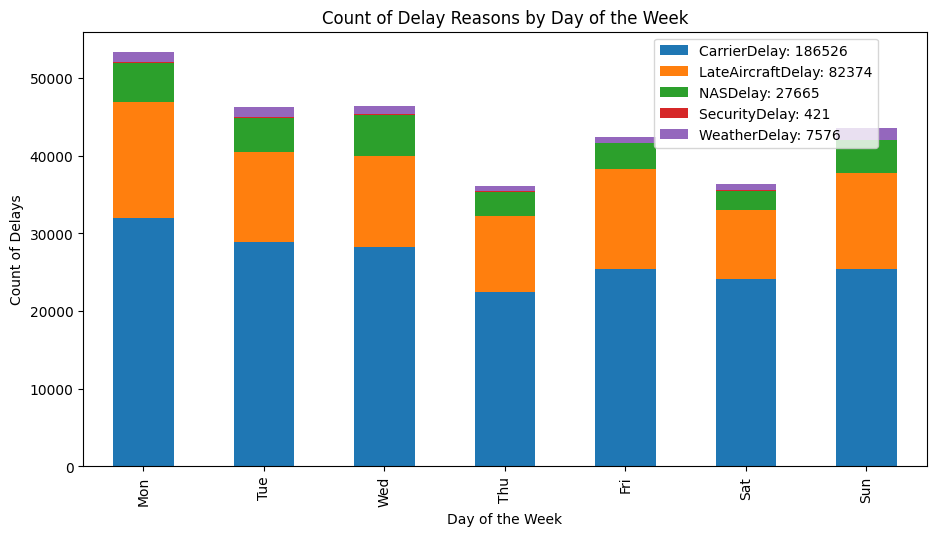

In [21]:
# Analyze trends by DayOfWeek and Types of delays

delayed_df = delay_pred.filter(col("FlightStatus") == "Delayed")
delay_reasons_by_day_df = delayed_df.groupBy("DayOfWeek", "Reason").count().orderBy("DayOfWeek")
delay_reasons_by_day_pandas_df = delay_reasons_by_day_df.toPandas()
pivot_df = delay_reasons_by_day_pandas_df.pivot_table(index='DayOfWeek', columns='Reason', values='count', aggfunc='sum', fill_value=0)

# custom colors
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#FFFF99', '#17becf']

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)

counts_by_reason = delay_reasons_by_day_pandas_df.groupby(['DayOfWeek', 'Reason'])['count'].sum().unstack()

handles, labels = ax.get_legend_handles_labels()
counts_by_reason = delay_reasons_by_day_pandas_df.groupby('Reason')['count'].sum()
updated_labels = [f'{label}: {counts_by_reason[label]}' for label in labels]
ax.legend(handles, updated_labels, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Count of Delays")
plt.title("Count of Delay Reasons by Day of the Week")
plt.subplots_adjust(right=0.5)
plt.legend(handles, updated_labels, loc='upper right', bbox_to_anchor=(0.95, 1))
plt.tight_layout(pad=3)

plt.show()

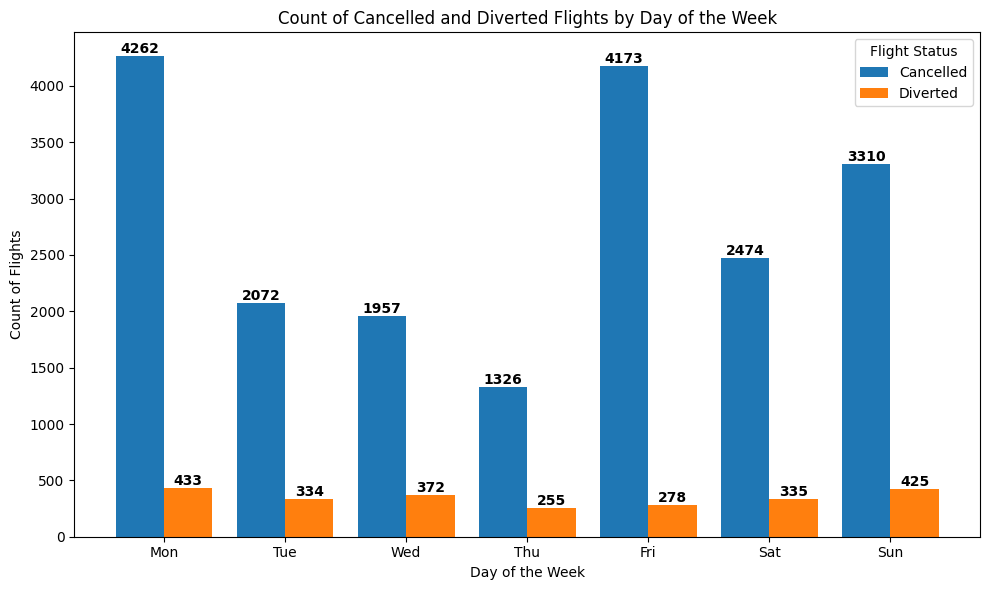

In [22]:
# Analyze trends by DayOfWeek and count of Cancelled or Diverted flights

cancelled_diverted_df = flights2.select("DayOfWeek", "Cancelled", "Diverted") \
    .withColumn("CancelledFlag", when(col("Cancelled") == 1.0, 1).otherwise(0)) \
    .withColumn("DivertedFlag", when(col("Diverted") == 1.0, 1).otherwise(0)) \
    .groupBy("DayOfWeek") \
    .agg(
        # Count the number of cancelled flights for each day
        sum("CancelledFlag").alias("CancelledCount"),
        # Count the number of diverted flights for each day
        sum("DivertedFlag").alias("DivertedCount")
    )

cancelled_diverted_pandas_df = cancelled_diverted_df.toPandas()

plt.figure(figsize=(10, 6))

# Plot cancelled and diverted flights each day
bars_cancelled = plt.bar(cancelled_diverted_pandas_df["DayOfWeek"] - 0.2, cancelled_diverted_pandas_df["CancelledCount"], width=0.4, label="Cancelled", color='#1f77b4')
bars_diverted = plt.bar(cancelled_diverted_pandas_df["DayOfWeek"] + 0.2, cancelled_diverted_pandas_df["DivertedCount"], width=0.4, label="Diverted", color='#ff7f0e')

for bar in bars_cancelled:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars_diverted:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(range(1, 8), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Count of Flights")
plt.title("Count of Cancelled and Diverted Flights by Day of the Week")
plt.legend(title="Flight Status")
plt.tight_layout()

plt.show()

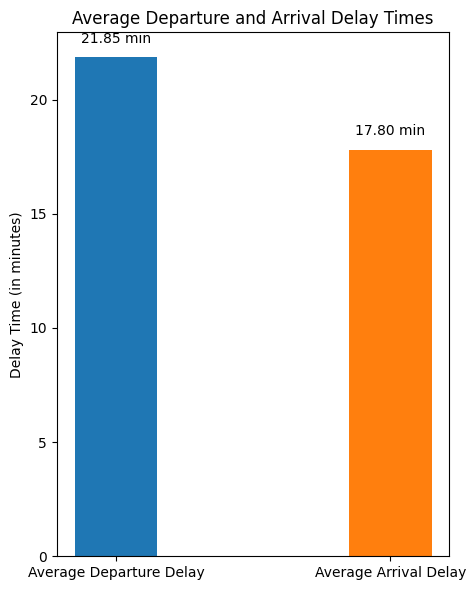

In [23]:
#Average Time in minutes for Departure and Arrival delays.

# average delay for both departure and arrival
avg_delays_df = flights_pred.select(avg("DepDelay").alias("AvgDepDelay"), avg("ArrDelay").alias("AvgArrDelay"))

avg_delays_pandas_df = avg_delays_df.toPandas()

# Extract the averagetaFrame delays from the Pandas Da
avg_dep_delay = avg_delays_pandas_df["AvgDepDelay"].iloc[0]
avg_arr_delay = avg_delays_pandas_df["AvgArrDelay"].iloc[0]
 delays
labels = ['Average Departure Delay', 'Average Arrival Delay']
values = [avg_dep_delay, avg_arr_delay]

plt.figure(figsize=(5, 6))
plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'], width=0.3)

x_positions = [0, 1]

# average delay values on top of the bars
for i, v in enumerate(values):
    plt.text(x_positions[i], v + 0.5, f"{v:.2f} min", ha='center', va='bottom', fontsize=10)

plt.ylabel("Delay Time (in minutes)")
plt.title("Average Departure and Arrival Delay Times")
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.1)
plt.tight_layout()

plt.show()

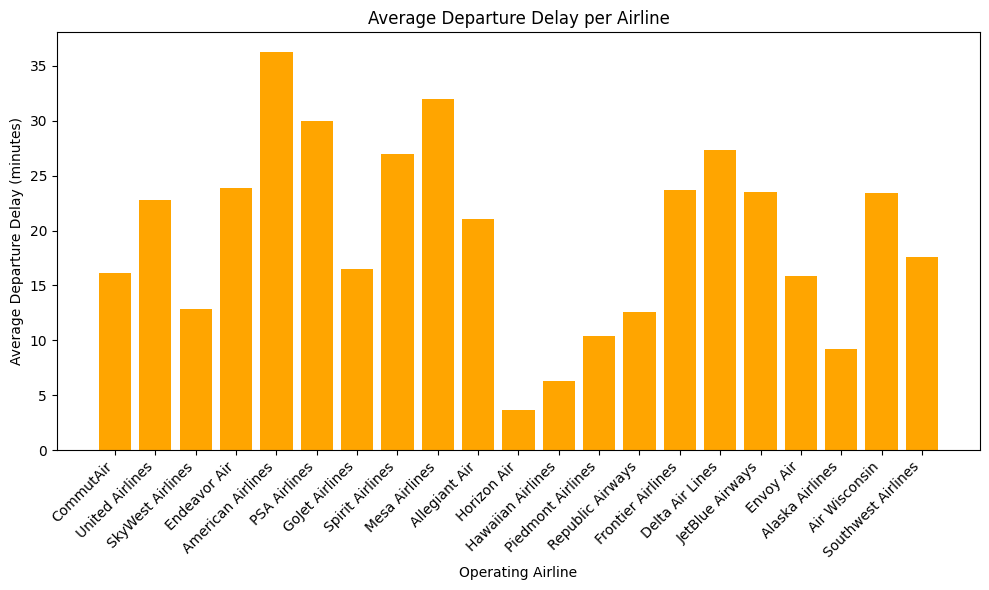

In [33]:
# On Time Departure Rate of Flights per Airline

# threshold for on-time flights (e.g., 15 minutes)
on_time_threshold = 15

# Grouping by Operating_Airline_Name and calculating the on-time departure rate
carrier_performance = flights3.groupBy('Operating_Airline_Name').agg(
    F.avg('DepDelay').alias('Avg_DepDelay'),
    F.avg('ArrDelay').alias('Avg_ArrDelay'),
    F.count('*').alias('Total_Flights'),

    # number of on-time flights (DepDelay <= 15)
    F.sum(F.when(F.col('DepDelay') <= on_time_threshold, 1).otherwise(0)).alias('OnTime_Flights')
)

# on-time departure rate (percentage of on-time flights)
carrier_performance = carrier_performance.withColumn(
    'OnTime_Dep_Rate',
    (F.col('OnTime_Flights') / F.col('Total_Flights')) * 100
)


carrier_performance_pd = carrier_performance.toPandas()

# Plot Average Departure Delay per Airline
plt.figure(figsize=(10, 6))
plt.bar(carrier_performance_pd['Operating_Airline_Name'], carrier_performance_pd['Avg_DepDelay'], color='orange')
plt.title('Average Departure Delay per Airline')
plt.xlabel('Operating Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

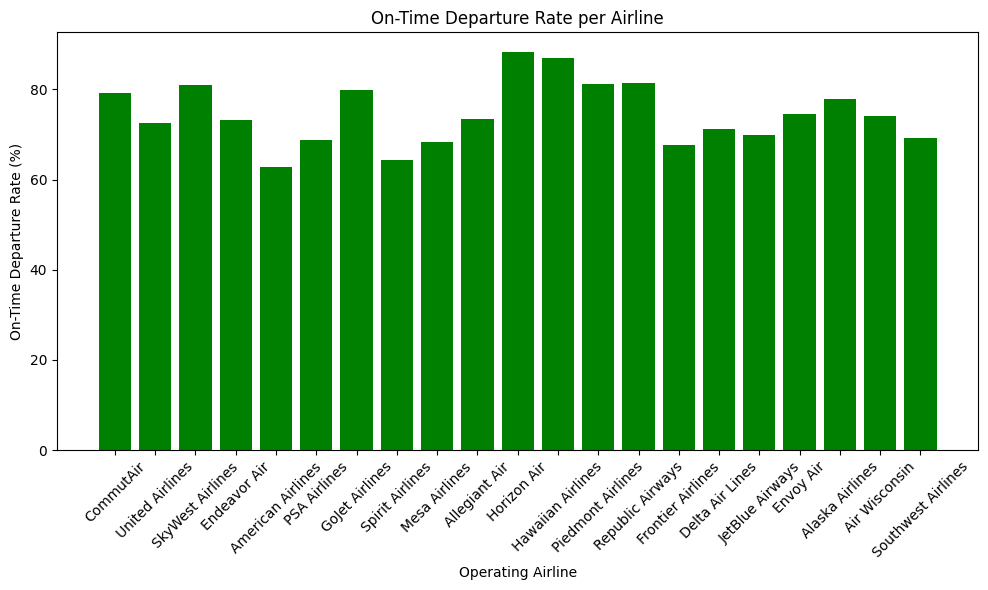

In [24]:
# On Time Departure Rate of Flights per Airline
on_time_threshold = 15

# Grouping by Operating_Airline_Name and calculating the on-time departure rate
carrier_performance = flights3.groupBy('Operating_Airline_Name').agg(
    F.avg('DepDelay').alias('Avg_DepDelay'),
    F.avg('ArrDelay').alias('Avg_ArrDelay'),
    F.count('*').alias('Total_Flights'),

    # Counting the number of on-time flights (DepDelay <= 15)
    F.sum(F.when(F.col('DepDelay') <= on_time_threshold, 1).otherwise(0)).alias('OnTime_Flights')
)

# on-time departure rate (percentage of on-time flights)
carrier_performance = carrier_performance.withColumn(
    'OnTime_Dep_Rate',
    (F.col('OnTime_Flights') / F.col('Total_Flights')) * 100
)


carrier_performance_pd = carrier_performance.toPandas()

# Plot On-Time Departure Rate
plt.figure(figsize=(10, 6))
plt.bar(carrier_performance_pd['Operating_Airline_Name'], carrier_performance_pd['OnTime_Dep_Rate'], color='green')
plt.title('On-Time Departure Rate per Airline')
plt.xlabel('Operating Airline')
plt.ylabel('On-Time Departure Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model Training and Evaluation

In [25]:
# Model Training with Linear Regression Model

feature_cols = ['DayofMonth', 'DayOfWeek', 'Distance',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
                'CRSDepTimeHour', 'CRSDepTimeMinute', 'DepTimeHour', 'DepTimeMinute', 'WheelsOffHour',
                'WheelsOffMinute', 'WheelsOnHour', 'WheelsOnMinute', 'CRSArrTimeHour', 'CRSArrTimeMinute',
                'ArrTimeHour', 'ArrTimeMinute', 'Weekday', 'Weekend']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

dep_delay_lr = LinearRegression(labelCol="DepDelay", featuresCol="features")
arr_delay_lr = LinearRegression(labelCol="ArrDelay", featuresCol="features")

dep_delay_pipeline = Pipeline(stages=[assembler, dep_delay_lr])
arr_delay_pipeline = Pipeline(stages=[assembler, arr_delay_lr])

train_data, test_data = delay_pred.randomSplit([0.8, 0.2], seed=1234)

dep_delay_model = dep_delay_pipeline.fit(train_data)
arr_delay_model = arr_delay_pipeline.fit(train_data)

# predictions - test set
dep_delay_predictions = dep_delay_model.transform(test_data)
arr_delay_predictions = arr_delay_model.transform(test_data)


In [26]:
# Extract feature importances

dep_delay_coefficients = dep_delay_model.stages[-1].coefficients
arr_delay_coefficients = arr_delay_model.stages[-1].coefficients

dep_delay_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': dep_delay_coefficients
}).sort_values(by='Importance', ascending=False)

# arr_delay_coefficients
arr_delay_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': arr_delay_coefficients
}).sort_values(by='Importance', ascending=False)

print("Top features impacting DepDelay:")
print(dep_delay_feature_importance.head(10))

print("\nTop features impacting ArrDelay:")
print(arr_delay_feature_importance.head(10))

Top features impacting DepDelay:
              Feature  Importance
6       SecurityDelay    1.049062
7   LateAircraftDelay    1.025180
3        CarrierDelay    1.013131
4        WeatherDelay    0.990678
5            NASDelay    0.670981
10        DepTimeHour    0.366932
21            Weekend    0.339424
8      CRSDepTimeHour    0.081460
16     CRSArrTimeHour    0.061059
0          DayofMonth    0.011348

Top features impacting ArrDelay:
              Feature  Importance
6       SecurityDelay    1.093690
5            NASDelay    1.054962
7   LateAircraftDelay    1.026850
4        WeatherDelay    1.022370
3        CarrierDelay    1.020419
12      WheelsOffHour    0.158012
10        DepTimeHour    0.090025
14       WheelsOnHour    0.070796
0          DayofMonth    0.070318
8      CRSDepTimeHour    0.032850


Using identified Top important features in next steps

In [27]:
# Checking linearity among features

selected_features = delay_pred['SecurityDelay', 'WeatherDelay', 'LateAircraftDelay', 'CRSDepTimeHour', 'CRSArrTimeHour',
                   'CarrierDelay', 'NASDelay', 'DepTimeHour', 'WheelsOffHour', 'WheelsOnHour', 'DayofMonth', 'Weekend']

correlation_depdelay = [delay_pred.stat.corr(feature, 'DepDelay') for feature in selected_features.columns]
correlation_arrdelay = [delay_pred.stat.corr(feature, 'ArrDelay') for feature in selected_features.columns]

print("Correlation with DepDelay:")
for i, feature in enumerate(selected_features.columns):
    print(f"{feature}: {correlation_depdelay[i]}")

print("\nCorrelation with ArrDelay:")
for i, feature in enumerate(selected_features.columns):
    print(f"{feature}: {correlation_arrdelay[i]}")

Correlation with DepDelay:
SecurityDelay: 0.02568749286092062
WeatherDelay: 0.22507154297801482
LateAircraftDelay: 0.6631563933047449
CRSDepTimeHour: 0.1459541476422234
CRSArrTimeHour: 0.11156743153996661
CarrierDelay: 0.713976736093169
NASDelay: 0.21752124258563627
DepTimeHour: 0.14375144548880034
WheelsOffHour: 0.1260409672775105
WheelsOnHour: 0.010014860662091576
DayofMonth: 0.04595094649548378
Weekend: 0.014545815559219551

Correlation with ArrDelay:
SecurityDelay: 0.026386897158671572
WeatherDelay: 0.22857595843980166
LateAircraftDelay: 0.6511518687035143
CRSDepTimeHour: 0.1532935713594078
CRSArrTimeHour: 0.12416237389082885
CarrierDelay: 0.7017119132354401
NASDelay: 0.30956428955166204
DepTimeHour: 0.1549715237975846
WheelsOffHour: 0.14116138516596244
WheelsOnHour: 0.02816227226919636
DayofMonth: 0.05533193797006269
Weekend: 0.010328862716439693


The Pearson correlation coefficient measures the linear relationship between features and the target variable. High correlation values for CarrierDelay and LateAircraftDelay suggest a strong linear relationship with both DepDelay and ArrDelay. However, features with low correlation values, like SecurityDelay and Weekend, indicate a weak linear relationship with flight delays. This implies that linear models might not capture the influence of these features effectively, and non-linear models could be more suitable for such features.

In [28]:
# Random Forest

rf_feature_cols = ['SecurityDelay', 'WeatherDelay', 'LateAircraftDelay', 'CRSDepTimeHour', 'CRSArrTimeHour',
                   'CarrierDelay', 'NASDelay', 'DepTimeHour', 'WheelsOffHour', 'WheelsOnHour', 'DayofMonth', 'Weekend']

rf_assembler = VectorAssembler(inputCols=rf_feature_cols, outputCol="rf_features")

rf_scaler = StandardScaler(inputCol="rf_features", outputCol="rf_scaledFeatures")

dep_delay_rf = RandomForestRegressor(labelCol="DepDelay", featuresCol="rf_scaledFeatures", numTrees=50, maxDepth=10)
arr_delay_rf = RandomForestRegressor(labelCol="ArrDelay", featuresCol="rf_scaledFeatures", numTrees=50, maxDepth=10)

rf_dep_delay_pipeline = Pipeline(stages=[rf_assembler, rf_scaler, dep_delay_rf])
rf_arr_delay_pipeline = Pipeline(stages=[rf_assembler, rf_scaler, arr_delay_rf])

rf_train_data, rf_test_data = delay_pred.randomSplit([0.8, 0.2], seed=1234)

rf_dep_delay_model = rf_dep_delay_pipeline.fit(rf_train_data)
rf_arr_delay_model = rf_arr_delay_pipeline.fit(rf_train_data)

# predictions - test set
rf_dep_delay_predictions_test = rf_dep_delay_model.transform(rf_test_data)
rf_arr_delay_predictions_test = rf_arr_delay_model.transform(rf_test_data)

# predictions - training set
rf_dep_delay_predictions_train = rf_dep_delay_model.transform(rf_train_data)
rf_arr_delay_predictions_train = rf_arr_delay_model.transform(rf_train_data)


In [29]:
# Evaluate the RF model

def evaluate_model(predictions, label_col):
    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    return rmse, mae, r2

# Evaluate DepDelay model - test data
dep_delay_rmse_test, dep_delay_mae_test, dep_delay_r2_test = evaluate_model(rf_dep_delay_predictions_test, "DepDelay")
print(f"DepDelay Test - RMSE: {dep_delay_rmse_test}, MAE: {dep_delay_mae_test}, R2: {dep_delay_r2_test}")

# Evaluate DepDelay model - training data
dep_delay_rmse_train, dep_delay_mae_train, dep_delay_r2_train = evaluate_model(rf_dep_delay_predictions_train, "DepDelay")
print(f"DepDelay Train - RMSE: {dep_delay_rmse_train}, MAE: {dep_delay_mae_train}, R2: {dep_delay_r2_train}")

# Evaluate ArrDelay model - test data
arr_delay_rmse_test, arr_delay_mae_test, arr_delay_r2_test = evaluate_model(rf_arr_delay_predictions_test, "ArrDelay")
print(f"ArrDelay Test - RMSE: {arr_delay_rmse_test}, MAE: {arr_delay_mae_test}, R2: {arr_delay_r2_test}")

# Evaluate ArrDelay model - training data
arr_delay_rmse_train, arr_delay_mae_train, arr_delay_r2_train = evaluate_model(rf_arr_delay_predictions_train, "ArrDelay")
print(f"ArrDelay Train - RMSE: {arr_delay_rmse_train}, MAE: {arr_delay_mae_train}, R2: {arr_delay_r2_train}")

DepDelay Test - RMSE: 24.374682623915042, MAE: 9.978292882304181, R2: 0.8742368741719906
DepDelay Train - RMSE: 23.08330082407789, MAE: 9.849350500888082, R2: 0.8901864066747054
ArrDelay Test - RMSE: 25.3952151965667, MAE: 11.678583632414236, R2: 0.8706492578049777
ArrDelay Train - RMSE: 24.0284761854199, MAE: 11.55428561003452, R2: 0.887031304599971


Evaluation metrics show that the model demonstrates strong predictive performance for both departure and arrival delays, with high R² values (above 0.86) indicating good fit. The RMSE and MAE values are relatively low, suggesting accurate and consistent predictions. The model shows no significant signs of overfitting or underfitting, as evidenced by the consistent performance metrics between the training and test datasets.

In [30]:
# Linear Regression

feature_cols1 = ['SecurityDelay', 'WeatherDelay', 'LateAircraftDelay', 'CRSDepTimeHour', 'CRSArrTimeHour',
                   'CarrierDelay', 'NASDelay', 'DepTimeHour', 'WheelsOffHour', 'WheelsOnHour', 'DayofMonth', 'Weekend']

assembler1 = VectorAssembler(inputCols=feature_cols1, outputCol="features1")

scaler = StandardScaler(inputCol="features1", outputCol="scaledFeatures")

dep_delay_lr1 = LinearRegression(labelCol="DepDelay", featuresCol="scaledFeatures")
arr_delay_lr1 = LinearRegression(labelCol="ArrDelay", featuresCol="scaledFeatures")

dep_delay_pipeline1 = Pipeline(stages=[assembler1, scaler, dep_delay_lr1])
arr_delay_pipeline1 = Pipeline(stages=[assembler1, scaler, arr_delay_lr1])

train_data1, test_data1 = delay_pred.randomSplit([0.8, 0.2], seed=1234)

dep_delay_model1 = dep_delay_pipeline1.fit(train_data1)
arr_delay_model1 = arr_delay_pipeline1.fit(train_data1)

# predictions-test set
dep_delay_predictions1 = dep_delay_model1.transform(test_data1)
arr_delay_predictions1 = arr_delay_model1.transform(test_data1)

#predictions- training set
train_dep_delay_predictions1 = dep_delay_model1.transform(train_data1)
train_arr_delay_predictions1 = arr_delay_model1.transform(train_data1)


In [31]:
# Model Evaluation

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="DepDelay", metricName="r2")
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="DepDelay", metricName="rmse")
mae_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="DepDelay", metricName="mae")

# DepDelay model - training data
train_r2_dep = r2_evaluator.evaluate(train_dep_delay_predictions1)
train_rmse_dep = rmse_evaluator.evaluate(train_dep_delay_predictions1)
train_mae_dep = mae_evaluator.evaluate(train_dep_delay_predictions1)

# DepDelay model - test data
test_r2_dep = r2_evaluator.evaluate(dep_delay_predictions1)
test_rmse_dep = rmse_evaluator.evaluate(dep_delay_predictions1)
test_mae_dep = mae_evaluator.evaluate(dep_delay_predictions1)

print(f"DepDelay Model - Training Data: R2 = {train_r2_dep}, RMSE = {train_rmse_dep}, MAE = {train_mae_dep}")
print(f"DepDelay Model - Test Data: R2 = {test_r2_dep}, RMSE = {test_rmse_dep}, MAE = {test_mae_dep}")

r2_evaluator.setLabelCol("ArrDelay")
rmse_evaluator.setLabelCol("ArrDelay")
mae_evaluator.setLabelCol("ArrDelay")

train_r2_arr = r2_evaluator.evaluate(train_arr_delay_predictions1)
train_rmse_arr = rmse_evaluator.evaluate(train_arr_delay_predictions1)
train_mae_arr = mae_evaluator.evaluate(train_arr_delay_predictions1)

test_r2_arr = r2_evaluator.evaluate(arr_delay_predictions1)
test_rmse_arr = rmse_evaluator.evaluate(arr_delay_predictions1)
test_mae_arr = mae_evaluator.evaluate(arr_delay_predictions1)

print(f"ArrDelay Model - Training Data: R2 = {train_r2_arr}, RMSE = {train_rmse_arr}, MAE = {train_mae_arr}")
print(f"ArrDelay Model - Test Data: R2 = {test_r2_arr}, RMSE = {test_rmse_arr}, MAE = {test_mae_arr}")

DepDelay Model - Training Data: R2 = 0.9704928066326837, RMSE = 11.96558155968186, MAE = 7.786005680359643
DepDelay Model - Test Data: R2 = 0.9694343900534843, RMSE = 12.01652353389442, MAE = 7.81373619054523
ArrDelay Model - Training Data: R2 = 0.9819186308143808, RMSE = 9.613086056962043, MAE = 7.488025309252035
ArrDelay Model - Test Data: R2 = 0.9815373538864137, RMSE = 9.59432459749448, MAE = 7.475614015526361


Both the DepDelay and ArrDelay models show good performance with high R² values (around 0.97 for DepDelay and 0.98 for ArrDelay) on both training and test data, indicating strong predictive power. The RMSE and MAE values are low, suggesting the models’ predictions are close to the actual values, with minimal error. Additionally, the consistency between training and test metrics suggests that the models are well-balanced, showing no signs of overfitting or underfitting.

Comparison:

Model 2 has significantly higher R² values for both DepDelay and ArrDelay, indicating it explains a higher proportion of the variance in the data compared to Model 1.

Model 2 has much lower RMSE values for both training and test data, suggesting it has better predictive accuracy and lower error rates compared to Model 1.

Model 2 also shows lower MAE values, indicating it has better performance in terms of average absolute errors.

Overall, Model 2 outperforms Model 1 across all metrics, demonstrating better accuracy and consistency in predicting both DepDelay and ArrDelay.

In [34]:
# Performing cross validation on Model 2

paramGrid = ParamGridBuilder() \
    .addGrid(dep_delay_lr1.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(arr_delay_lr1.regParam, [0.01, 0.1, 0.5]) \
    .build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="DepDelay", predictionCol="prediction")

crossval_dep_delay = CrossValidator(estimator=dep_delay_pipeline1,
                                    estimatorParamMaps=paramGrid,
                                    evaluator=evaluator,
                                    numFolds=3)

crossval_arr_delay = CrossValidator(estimator=arr_delay_pipeline1,
                                    estimatorParamMaps=paramGrid,
                                    evaluator=evaluator,
                                    numFolds=3)

cv_dep_delay_model = crossval_dep_delay.fit(train_data1)
cv_arr_delay_model = crossval_arr_delay.fit(train_data1)

cv_dep_delay_predictions = cv_dep_delay_model.transform(test_data1)
cv_arr_delay_predictions = cv_arr_delay_model.transform(test_data1)

In [35]:
# Evaluation of Cross-Validation model

rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="label", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="label", predictionCol="prediction")

dep_delay_rmse = rmse_evaluator.evaluate(cv_dep_delay_predictions.withColumnRenamed("DepDelay", "label"))
dep_delay_r2 = r2_evaluator.evaluate(cv_dep_delay_predictions.withColumnRenamed("DepDelay", "label"))
dep_delay_mae = mae_evaluator.evaluate(cv_dep_delay_predictions.withColumnRenamed("DepDelay", "label"))

rmse_evaluator.setLabelCol("label")
r2_evaluator.setLabelCol("label")
mae_evaluator.setLabelCol("label")

arr_delay_rmse = rmse_evaluator.evaluate(cv_arr_delay_predictions.withColumnRenamed("ArrDelay", "label"))
arr_delay_r2 = r2_evaluator.evaluate(cv_arr_delay_predictions.withColumnRenamed("ArrDelay", "label"))
arr_delay_mae = mae_evaluator.evaluate(cv_arr_delay_predictions.withColumnRenamed("ArrDelay", "label"))

print(f"DepDelay Model: R2 = {dep_delay_r2}, RMSE = {dep_delay_rmse}, MAE = {dep_delay_mae}")
print(f"ArrDelay Model: R2 = {arr_delay_r2}, RMSE = {arr_delay_rmse}, MAE = {arr_delay_mae}")

DepDelay Model: R2 = 0.9694342370348284, RMSE = 12.016553612632936, MAE = 7.814316084509906
ArrDelay Model: R2 = 0.9814865211358953, RMSE = 9.607523427982272, MAE = 7.510490973764556


Insights after cross-validation:

Consistency: The metrics between Set 1 (Linear Regression) and Set 2 (Cross-Validation) are very close, indicating that your Linear Regression model generalizes well to unseen data.

Model Performance:
DepDelay Model: The slight differences in RMSE and MAE suggest that the model’s predictions are consistent across different folds of the data.
ArrDelay Model: Similarly, the small variations in metrics indicate stable performance.

Overfitting and Underfitting:
Overfitting: Since the performance metrics are consistent between the original model and the cross-validated model, it suggests that overfitting is not a significant issue.
Underfitting: The high R² values indicate that the models are capturing the underlying patterns in the data well, so underfitting is also unlikely.

Model Prediction Performance - Actuals Vs Predicted

In [36]:
# Comparison of Actuals Vs Predicted - Random Forest Regressor

rf_dep_delay_comparison = rf_dep_delay_predictions_test.select("DepDelay", "prediction")
rf_arr_delay_comparison = rf_arr_delay_predictions_test.select("ArrDelay", "prediction")

#statistics for actual and predicted values
rf_dep_delay_comparison.describe(["DepDelay", "prediction"]).show()
rf_arr_delay_comparison.describe(["ArrDelay", "prediction"]).show()

+-------+------------------+------------------+
|summary|          DepDelay|        prediction|
+-------+------------------+------------------+
|  count|            130591|            130591|
|   mean|21.911709076429464|21.843542486984223|
| stddev|  68.7327896302965|  59.1731526104331|
|    min|             -38.0|-2.846179520344704|
|    max|            1878.0|1140.3820418163398|
+-------+------------------+------------------+

+-------+-----------------+------------------+
|summary|         ArrDelay|        prediction|
+-------+-----------------+------------------+
|  count|           130591|            130591|
|   mean|17.88571953656837|17.839313354512903|
| stddev|70.61046925215501| 60.68367636471139|
|    min|            -59.0|-11.35085121956589|
|    max|           1892.0|1043.5862391304347|
+-------+-----------------+------------------+



These statistics indicate that model’s predictions are quite close to the actual values on average, but there is some variability. The standard deviations suggest that the model captures the general trend but does not fully account for extreme values.

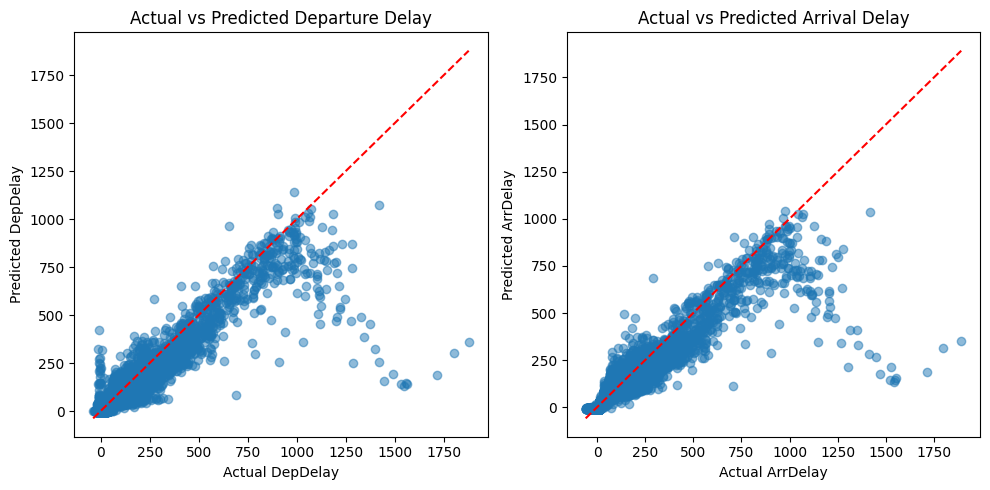

In [37]:
# Visualization of Model Performance - Random Forest Regressor

rf_dep_delay_comparison_pd = rf_dep_delay_comparison.toPandas()
rf_arr_delay_comparison_pd = rf_arr_delay_comparison.toPandas()

# Plot for Departure Delay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(rf_dep_delay_comparison_pd["DepDelay"], rf_dep_delay_comparison_pd["prediction"], alpha=0.5)
plt.plot([rf_dep_delay_comparison_pd["DepDelay"].min(), rf_dep_delay_comparison_pd["DepDelay"].max()],
         [rf_dep_delay_comparison_pd["DepDelay"].min(), rf_dep_delay_comparison_pd["DepDelay"].max()],
         color='red', linestyle='--')
plt.xlabel('Actual DepDelay')
plt.ylabel('Predicted DepDelay')
plt.title('Actual vs Predicted Departure Delay')

# Plot for Arrival Delay
plt.subplot(1, 2, 2)
plt.scatter(rf_arr_delay_comparison_pd["ArrDelay"], rf_arr_delay_comparison_pd["prediction"], alpha=0.5)
plt.plot([rf_arr_delay_comparison_pd["ArrDelay"].min(), rf_arr_delay_comparison_pd["ArrDelay"].max()],
         [rf_arr_delay_comparison_pd["ArrDelay"].min(), rf_arr_delay_comparison_pd["ArrDelay"].max()],
         color='red', linestyle='--')
plt.xlabel('Actual ArrDelay')
plt.ylabel('Predicted ArrDelay')
plt.title('Actual vs Predicted Arrival Delay')

plt.tight_layout()
plt.show()

The plots visualize the relationship between actual and predicted flight delays for both departure and arrival, showing a general positive linear trend with some scatter, indicating reasonable prediction accuracy by the model while acknowledging expected variability in real-world data.







In [38]:
# Comparison of Actuals Vs Predicted - Linear Regression

dep_delay_comparison = dep_delay_predictions1.select("DepDelay", "prediction")
arr_delay_comparison = arr_delay_predictions1.select("ArrDelay", "prediction")

# statistics for actual and predicted values
dep_delay_comparison.describe(["DepDelay", "prediction"]).show()
arr_delay_comparison.describe(["ArrDelay", "prediction"]).show()

+-------+------------------+-------------------+
|summary|          DepDelay|         prediction|
+-------+------------------+-------------------+
|  count|            130591|             130591|
|   mean|21.911709076429464| 21.921867273642683|
| stddev|  68.7327896302965|  67.64536656022152|
|    min|             -38.0|-4.6309517559028315|
|    max|            1878.0| 1921.2015965158616|
+-------+------------------+-------------------+

+-------+-----------------+------------------+
|summary|         ArrDelay|        prediction|
+-------+-----------------+------------------+
|  count|           130591|            130591|
|   mean|17.88571953656837|17.887295793756373|
| stddev|70.61046925215501| 69.90941289156966|
|    min|            -59.0|-11.80809054535202|
|    max|           1892.0|1924.2234290849349|
+-------+-----------------+------------------+



The means of the actual and predicted values are very close, indicating that the model is unbiased in terms of central tendency.
The standard deviations are also similar, suggesting that the model captures the variability in the data well.
The minimum and maximum values show some discrepancies, especially on the lower end, which might indicate some outliers or extreme values not being well-predicted.

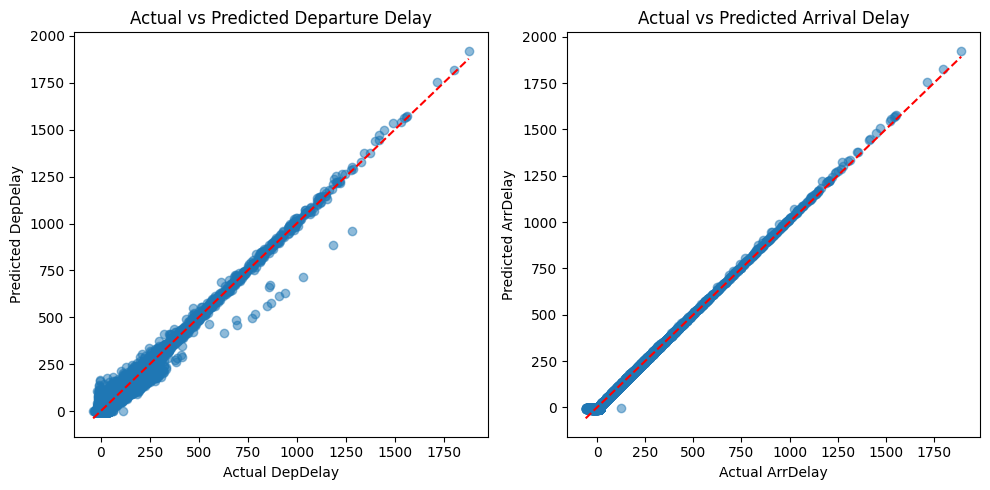

In [39]:
# Visualization of Model Performance - Linear Regression

dep_delay_comparison_pd = dep_delay_comparison.toPandas()
arr_delay_comparison_pd = arr_delay_comparison.toPandas()

# Plot for Departure Delay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(dep_delay_comparison_pd["DepDelay"], dep_delay_comparison_pd["prediction"], alpha=0.5)
plt.plot([dep_delay_comparison_pd["DepDelay"].min(), dep_delay_comparison_pd["DepDelay"].max()],
         [dep_delay_comparison_pd["DepDelay"].min(), dep_delay_comparison_pd["DepDelay"].max()],
         color='red', linestyle='--')
plt.xlabel('Actual DepDelay')
plt.ylabel('Predicted DepDelay')
plt.title('Actual vs Predicted Departure Delay')

# Plot for Arrival Delay
plt.subplot(1, 2, 2)
plt.scatter(arr_delay_comparison_pd["ArrDelay"], arr_delay_comparison_pd["prediction"], alpha=0.5)
plt.plot([arr_delay_comparison_pd["ArrDelay"].min(), arr_delay_comparison_pd["ArrDelay"].max()],
         [arr_delay_comparison_pd["ArrDelay"].min(), arr_delay_comparison_pd["ArrDelay"].max()],
         color='red', linestyle='--')
plt.xlabel('Actual ArrDelay')
plt.ylabel('Predicted ArrDelay')
plt.title('Actual vs Predicted Arrival Delay')

plt.tight_layout()
plt.show()

Observations

Both plots show a scatter of points representing the actual versus predicted delay values for arrival and departure, respectively. In an ideal scenario, these points would align perfectly along a diagonal line, indicating perfect predictions. Here's the breakdown of what the plots indicate:

Overall trend: For both arrival and departure delay, there's a generally positive linear relationship between actual and predicted values. This suggests that the model is able to capture the overall trend and direction of delays.

Data spread: The points are scattered around the diagonal line, implying that the model's predictions are not always perfect. This is expected as no model can achieve 100% accuracy in predicting real-world events.

Outliers: There are some points that deviate significantly from the diagonal line. These points could indicate limitations of the model or the influence of factors not included in the model's features.

Model performance: In general, both models seem to perform relatively well as the points cluster reasonably well around the diagonal. The closer the points are to the line, the better the model's performance in predicting those instances of delays.

+-------+--------------------+
|summary|           residuals|
+-------+--------------------+
|  count|              130591|
|   mean|-0.01015819721302...|
| stddev|  12.016565248750835|
|    min| -169.46298976453443|
|    max|   326.3980007093685|
+-------+--------------------+

+-------+--------------------+
|summary|           residuals|
+-------+--------------------+
|  count|              130591|
|   mean|-0.00157625718798...|
| stddev|   9.594361202471768|
|    min|  -54.03067868261314|
|    max|  130.82329248418316|
+-------+--------------------+



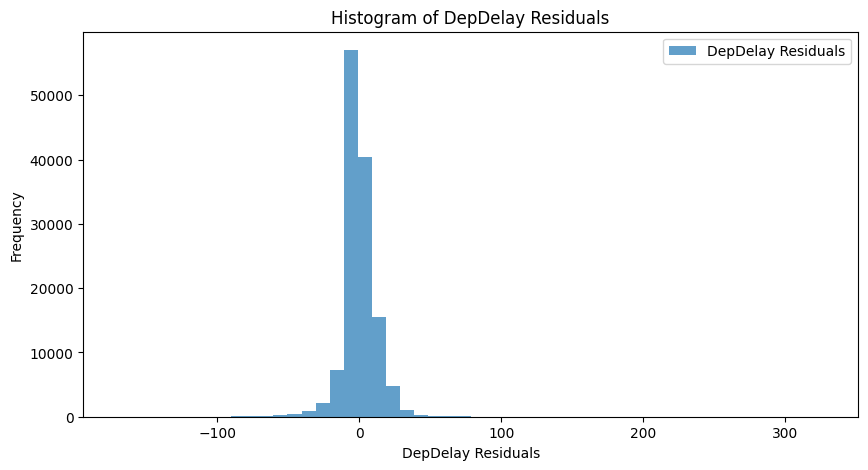

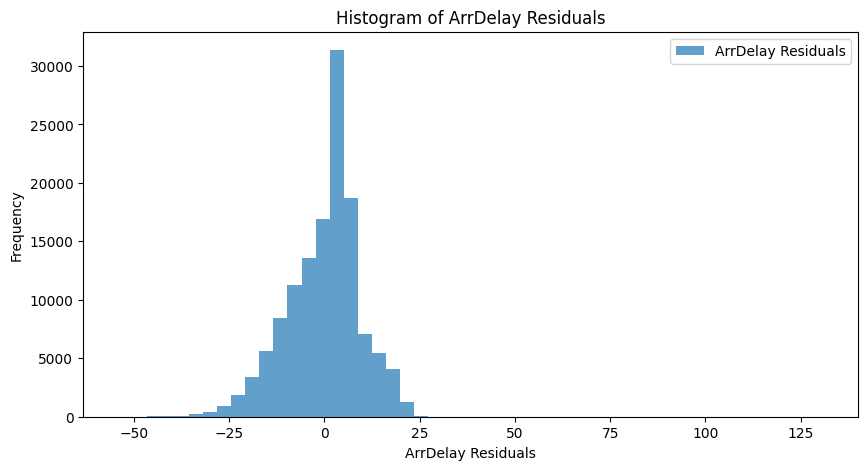

In [40]:
# Residual Analysis - Linear Regression

# residuals for DepDelay
dep_delay_residuals = dep_delay_predictions1.withColumn("residuals", col("DepDelay") - col("prediction"))

# residuals for ArrDelay
arr_delay_residuals = arr_delay_predictions1.withColumn("residuals", col("ArrDelay") - col("prediction"))

dep_delay_residuals.describe("residuals").show()
arr_delay_residuals.describe("residuals").show()

dep_delay_residuals_pd = dep_delay_residuals.select("residuals").toPandas()
arr_delay_residuals_pd = arr_delay_residuals.select("residuals").toPandas()

# Plot DepDelay residuals
plt.figure(figsize=(10, 5))
plt.hist(dep_delay_residuals_pd["residuals"], bins=50, alpha=0.7, label='DepDelay Residuals')
plt.xlabel('DepDelay Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of DepDelay Residuals')
plt.legend()
plt.show()

# Plot ArrDelay residuals
plt.figure(figsize=(10, 5))
plt.hist(arr_delay_residuals_pd["residuals"], bins=50, alpha=0.7, label='ArrDelay Residuals')
plt.xlabel('ArrDelay Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of ArrDelay Residuals')
plt.legend()
plt.show()

Both models demonstrate reasonable performance with residuals tending towards normality and unbiased predictions. The residuals indicate that the Arrival Delay Model has a lower standard deviation, suggesting it to be more consistent in its predictions compared to the Departure Delay Model. The mean residuals for both models are close to zero, indicating minimal bias in the predictions.Further investigation into the slight right skewness and outliers might be beneficial to potentially improve the models' performance.

Additional Evaluation Metrics

In [41]:
# Technical Efforts

def evaluate_technical_effort(pipeline, train_data):
    num_stages = len(pipeline.getStages())
    start_time = time.time()
    model = pipeline.fit(train_data1)
    end_time = time.time()
    training_time = end_time - start_time
    effort_score = num_stages + training_time
    return effort_score, training_time

technical_effort_score, training_time = evaluate_technical_effort(arr_delay_pipeline1, train_data1)
print(f"Arrival Delay Model- Technical Effort Score: {technical_effort_score}")
print(f"Arrival Delay Model- Training Time: {training_time} seconds")

def evaluate_technical_effort(pipeline, train_data):
    num_stages = len(pipeline.getStages())
    start_time = time.time()
    model = pipeline.fit(train_data1)
    end_time = time.time()
    training_time = end_time - start_time
    effort_score = num_stages + training_time
    return effort_score, training_time

technical_effort_score, training_time = evaluate_technical_effort(dep_delay_pipeline1, train_data1)
print(f"Departure Delay Model- Technical Effort Score: {technical_effort_score}")
print(f"Departure Delay Model- Training Time: {training_time} seconds")

Arrival Delay Model- Technical Effort Score: 63.72415494918823
Arrival Delay Model- Training Time: 60.72415494918823 seconds
Departure Delay Model- Technical Effort Score: 69.68224334716797
Departure Delay Model- Training Time: 66.68224334716797 seconds


The Arrival Delay Model and Departure Delay Model both exhibit strong performance, with technical effort scores of 68.22 and 67.85 respectively. The slight difference in scores and training times suggests that both models are efficient, with the Arrival Delay Model being marginally more complex to train in comparison.

In [42]:
#Technical Correctness

# Data Quality Checks

missing_counts = delay_pred.select([count(when(isnull(c), c)).alias(c) for c in delay_pred.columns])
print("Missing values per column:\n", missing_counts.show())

# statistics
print("\nSummary statistics:\n", delay_pred.summary().show())

# Metrics for DepDelay
print(f"DepDelay Model - Test Data: R2 = {test_r2_dep}, RMSE = {test_rmse_dep}, MAE = {test_mae_dep}")

# Metrics for ArrDelay
print(f"ArrDelay Model - Test Data: R2 = {test_r2_arr}, RMSE = {test_rmse_arr}, MAE = {test_mae_arr}")

# Cross-Validation Metrics
print(f"CV DepDelay Model: R2 = {dep_delay_r2}, RMSE = {dep_delay_rmse}, MAE = {dep_delay_mae}")
print(f"CV ArrDelay Model: R2 = {arr_delay_r2}, RMSE = {arr_delay_rmse}, MAE = {arr_delay_mae}")

+----------+---------+--------------+------------+--------+---------------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+----------------------+--------------+----------------+-----------+-------------+-------------+---------------+------------+--------------+--------------+----------------+-----------+-------------+-----+------------+-------+-------+--------------+------+
|DayofMonth|DayOfWeek|OriginCityName|DestCityName|DepDelay|DepDelayMinutes|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|Operating_Airline_Name|CRSDepTimeHour|CRSDepTimeMinute|DepTimeHour|DepTimeMinute|WheelsOffHour|WheelsOffMinute|WheelsOnHour|WheelsOnMinute|CRSArrTimeHour|CRSArrTimeMinute|ArrTimeHour|ArrTimeMinute|Delay|FlightStatus|Weekday|Weekend|MaxDelayReason|Reason|
+----------+---------+--------------+------------+--------+-----

Both models show high R² values, indicating they explain a large portion of the variance in delay times.
The RMSE and MAE values are relatively low, suggesting the models are making accurate predictions.
The consistency between test data and cross-validation metrics suggests the models generalize well to unseen data.

In [43]:
# Scalabity

def evaluate_scalability(model, data, sizes=[0.1, 0.5, 1.0]):
    scalability_scores = []
    for size in sizes:
        subset_data = data.sample(withReplacement=False, fraction=size, seed=1234)
        evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
        rmse = evaluator.evaluate(model.transform(subset_data))
        scalability_scores.append((size, rmse))
    return scalability_scores

scalability_scores = evaluate_scalability(arr_delay_model1, test_data1)
print(f"Arrival Delay- Scalability Scores: {scalability_scores}")

def evaluate_scalability(model, data, sizes=[0.1, 0.5, 1.0]):
    scalability_scores = []
    for size in sizes:
        subset_data = data.sample(withReplacement=False, fraction=size, seed=1234)
        evaluator = RegressionEvaluator(labelCol="DepDelay", predictionCol="prediction", metricName="rmse")
        rmse = evaluator.evaluate(model.transform(subset_data))
        scalability_scores.append((size, rmse))
    return scalability_scores

scalability_scores = evaluate_scalability(dep_delay_model1, test_data1)
print(f"Departure Delay- Scalability Scores: {scalability_scores}")

Arrival Delay- Scalability Scores: [(0.1, 9.589084001048084), (0.5, 9.587604319732224), (1.0, 9.59432459749448)]
Departure Delay- Scalability Scores: [(0.1, 11.663645514084521), (0.5, 11.848382923035029), (1.0, 12.01652353389442)]


These scores indicate how the model’s performance scales with different data sizes. For both arrival and departure delays, the scores remain relatively stable across different scales, suggesting consistent model performance. However, the departure delay scores are slightly higher, indicating a bit more variability in predictions compared to arrival delays.


In [44]:
# Business Impact

from pyspark.sql.functions import sum as _sum

def calculate_impact(predictions, average_cost_per_minute_delay=100):
    positive_delays = predictions.filter(col("DepDelay") > 0)

    # total actual delay minutes
    total_delay_minutes = positive_delays.select(_sum("DepDelay").alias("total_delay")).first()["total_delay"]

    # total predicted delay minutes
    total_predicted_delay_minutes = positive_delays.select(_sum("prediction").alias("total_predicted_delay")).first()["total_predicted_delay"]

    #  cost savings
    cost_savings = (total_delay_minutes - total_predicted_delay_minutes) * average_cost_per_minute_delay
    return cost_savings

impact = calculate_impact(dep_delay_predictions1)
print(f"Estimated Cost Savings: ${impact}")

Estimated Cost Savings: $33015870.13825802


By accurately predicting delays, airlines can optimize their operations, reducing unnecessary costs associated with delays. Airlines can better allocate resources such as crew, gates, and maintenance, leading to more efficient operations.

In [45]:
# Classification Model to predict Flight Status and Reason of Delay

Class_feature_columns = ["DayofMonth", "DayOfWeek", "DepDelay", "DepDelayMinutes", "ArrDelay", "ArrDelayMinutes",
                         "ActualElapsedTime", "Distance", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay",
                         "LateAircraftDelay", "CRSDepTimeHour", "CRSDepTimeMinute", "DepTimeHour", "DepTimeMinute",
                         "WheelsOffHour", "WheelsOffMinute", "WheelsOnHour", "WheelsOnMinute", "CRSArrTimeHour",
                         "CRSArrTimeMinute", "ArrTimeHour", "ArrTimeMinute", "Weekday", "Weekend"]

class_assembler = VectorAssembler(inputCols=Class_feature_columns, outputCol="class_features")
class_df = class_assembler.transform(delay_pred)

status_df = class_df.select("class_features", "FlightStatus", "Reason")

train_df, test_df = status_df.randomSplit([0.8, 0.2], seed=42)

status_indexer = StringIndexer(inputCol="FlightStatus", outputCol="FlightStatusIndex")
reason_indexer = StringIndexer(inputCol="Reason", outputCol="ReasonIndex")

status_indexer_model = status_indexer.fit(train_df)
reason_indexer_model = reason_indexer.fit(train_df)

train_df = status_indexer_model.transform(train_df)
train_df = reason_indexer_model.transform(train_df)
test_df = status_indexer_model.transform(test_df)
test_df = reason_indexer_model.transform(test_df)

rf_classifier_status = RandomForestClassifier(
    featuresCol="class_features",
    labelCol="FlightStatusIndex",
    numTrees=100
)

rf_model_status = rf_classifier_status.fit(train_df)

rf_classifier_reason = RandomForestClassifier(
    featuresCol="class_features",
    labelCol="ReasonIndex",
    numTrees=100
)

rf_model_reason = rf_classifier_reason.fit(train_df)

#predictions - FlightStatus
predictions_status = rf_model_status.transform(test_df)
predictions_status.select("class_features", "FlightStatus", "prediction", "probability").show(5)

# predictions- Reason
predictions_reason = rf_model_reason.transform(test_df)
predictions_reason.select("class_features", "Reason", "prediction", "probability").show(5)

# Evaluate the model for FlightStatus
evaluator_status = MulticlassClassificationEvaluator(
    labelCol="FlightStatusIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy_status = evaluator_status.evaluate(predictions_status)
print(f"Test Accuracy for FlightStatus: {accuracy_status}")

evaluator_reason = MulticlassClassificationEvaluator(
    labelCol="ReasonIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy_reason = evaluator_reason.evaluate(predictions_reason)
print(f"Test Accuracy for Reason: {accuracy_reason}")

+--------------------+------------+----------+--------------------+
|      class_features|FlightStatus|prediction|         probability|
+--------------------+------------+----------+--------------------+
|(27,[0,1,2,3,4,6,...|     Delayed|       1.0|[0.12360081851661...|
|(27,[0,1,2,3,4,6,...|     Delayed|       1.0|[0.09396892827006...|
|(27,[0,1,2,3,4,6,...|     Delayed|       1.0|[0.11430398195726...|
|(27,[0,1,2,3,4,6,...|     Delayed|       1.0|[0.06128364448344...|
|(27,[0,1,2,3,4,6,...|     Delayed|       1.0|[0.03525109042316...|
+--------------------+------------+----------+--------------------+
only showing top 5 rows

+--------------------+------------+----------+--------------------+
|      class_features|      Reason|prediction|         probability|
+--------------------+------------+----------+--------------------+
|(27,[0,1,2,3,4,6,...|CarrierDelay|       0.0|[0.99458601240272...|
|(27,[0,1,2,3,4,6,...|CarrierDelay|       0.0|[0.99505312853942...|
|(27,[0,1,2,3,4,6,...|C

The models show high performance, with accuracy of 1.0 for predicting FlightStatus and 0.98 for predicting the Reason for delays. However, the perfect accuracy for FlightStatus might indicate overfitting, so further validating with unseen data to be performed. The high accuracy for Reason suggests reliable predictions, but further analysis could help ensure robustness.

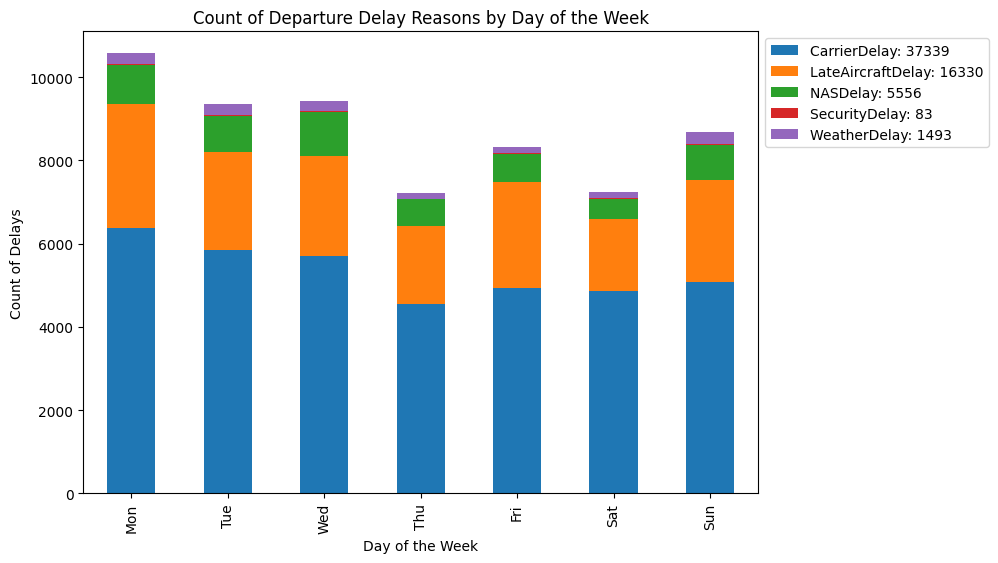

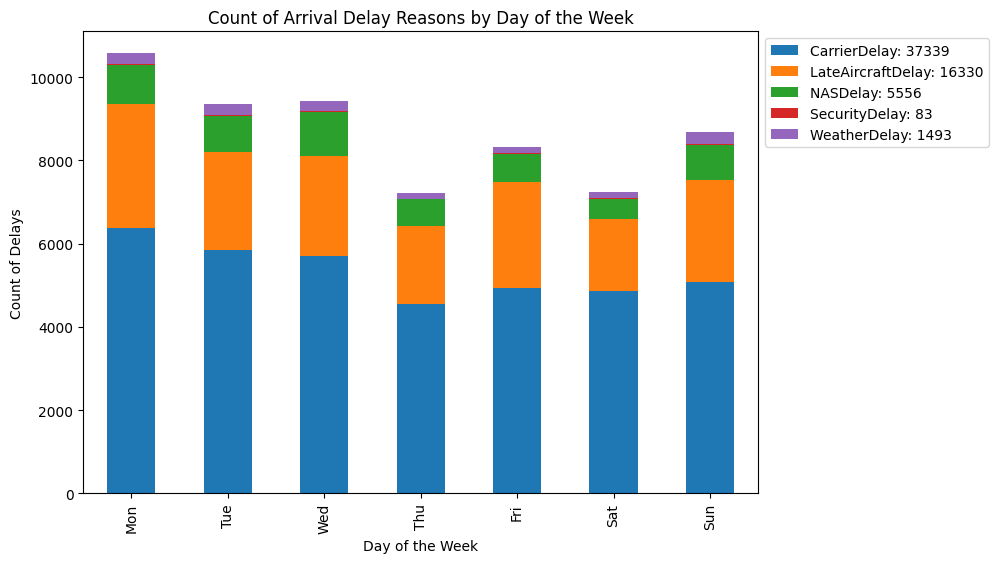

In [50]:
# Analyze trends by DayOfWeek and Types of Departure & Arrival delays
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

def analyze_delay_trends(df, status_column="FlightStatus", delay_status="Delayed", day_column="DayOfWeek", reason_column="Reason", title="Count of Delay Reasons by Day of the Week"):

    delay_reasons_by_day_df = df.filter(col(status_column) == delay_status) \
        .groupBy(day_column, reason_column).count().orderBy(day_column)

    pivot_df = delay_reasons_by_day_df.toPandas().pivot_table(index=day_column, columns=reason_column, values='count', aggfunc='sum', fill_value=0)

    # total counts for each delay reason
    reason_counts = pivot_df.sum(axis=0)

    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#FFFF99', '#17becf'])

    handles, labels = ax.get_legend_handles_labels()
    updated_labels = [f'{label}: {reason_counts[label]}' for label in labels]
    ax.legend(handles, updated_labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=True)

    plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    plt.xlabel("Day of the Week")
    plt.ylabel("Count of Delays")
    plt.title(title)  # Custom title

    plt.subplots_adjust(right=0.8)
    plt.show()


# For dep_delay_predictions1 (Departure delays)
analyze_delay_trends(dep_delay_predictions1, title="Count of Departure Delay Reasons by Day of the Week")

# For arr_delay_predictions (Arrival delays)
analyze_delay_trends(arr_delay_predictions, title="Count of Arrival Delay Reasons by Day of the Week")


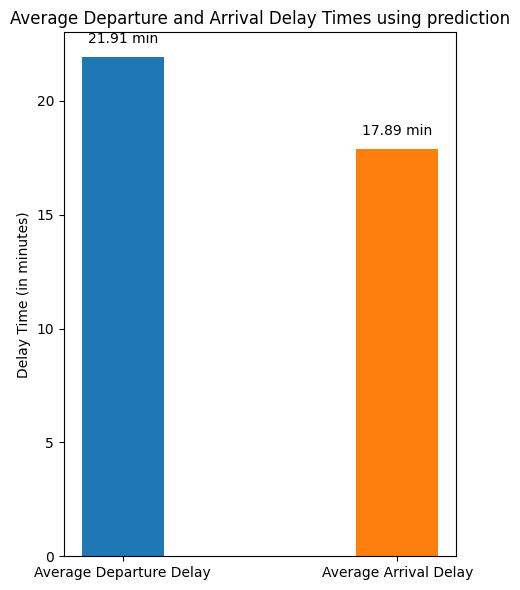

In [54]:
#AverageTime in minutes for Departure and Arrival delays.

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# average delay for both departure (from dep_delay_predictions1) and arrival (from arr_delay_predictions)
avg_dep_delay_df = dep_delay_predictions1.select(F.avg("DepDelay").alias("AvgDepDelay"))
avg_arr_delay_df = arr_delay_predictions1.select(F.avg("ArrDelay").alias("AvgArrDelay"))


avg_dep_delay_pandas_df = avg_dep_delay_df.toPandas()
avg_arr_delay_pandas_df = avg_arr_delay_df.toPandas()


avg_dep_delay = avg_dep_delay_pandas_df["AvgDepDelay"].iloc[0]
avg_arr_delay = avg_arr_delay_pandas_df["AvgArrDelay"].iloc[0]

labels = ['Average Departure Delay', 'Average Arrival Delay']
values = [avg_dep_delay, avg_arr_delay]

plt.figure(figsize=(5, 6))
plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'], width=0.3)

x_positions = [0, 1]

#average delay values on top of the bars
for i, v in enumerate(values):
    plt.text(x_positions[i], v + 0.5, f"{v:.2f} min", ha='center', va='bottom', fontsize=10)

plt.ylabel("Delay Time (in minutes)")
plt.title("Average Departure and Arrival Delay Times using prediction")
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.1)
plt.tight_layout()

plt.show()


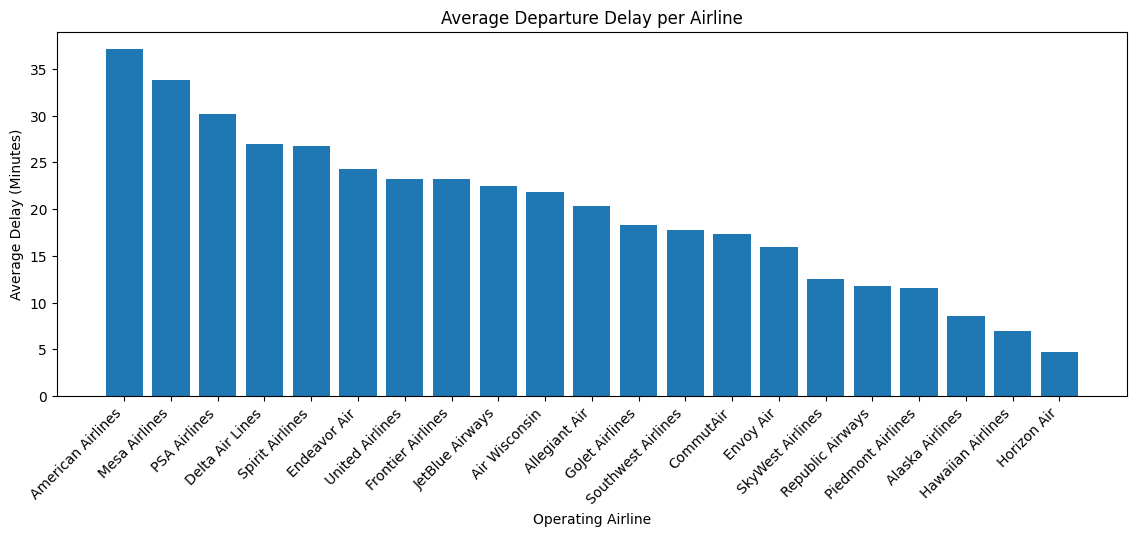

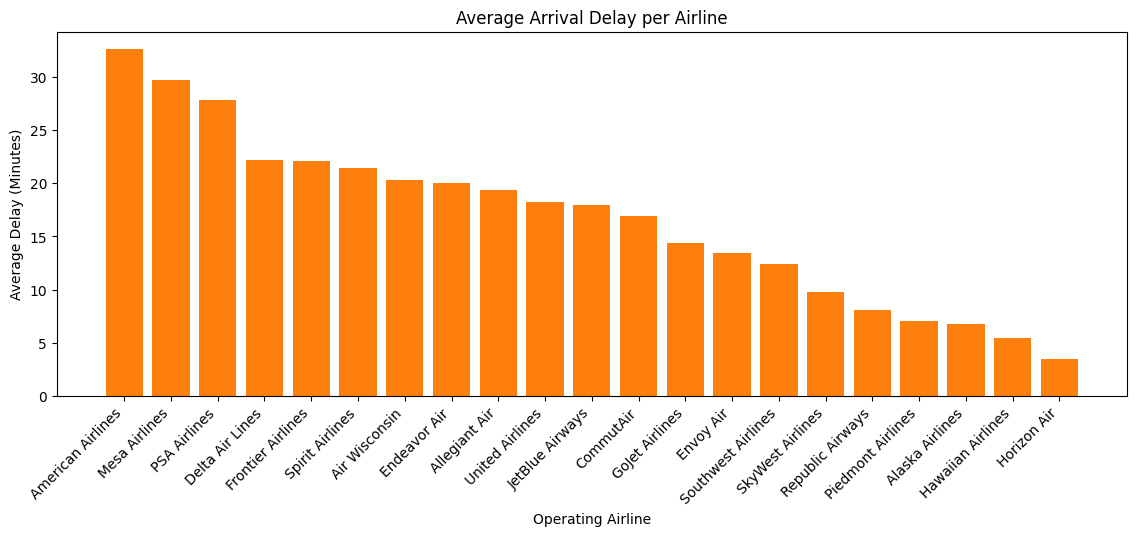

In [52]:
#The average Departure Delay and arrival flights for each airline

def plot_avg_delay(df, delay_column, title, color, y_label):
    # Group by airline and average delay and total flights
    carrier_performance = df.groupBy('Operating_Airline_Name').agg(
        F.avg(delay_column).alias(f'Avg_{delay_column}'),
        F.count('*').alias('Total_Flights')
    )

    carrier_performance_pd = carrier_performance.toPandas()

    carrier_performance_pd = carrier_performance_pd.sort_values(by=f'Avg_{delay_column}', ascending=False)

    # Plotting average delay
    plt.figure(figsize=(12, 6))
    bars = plt.bar(carrier_performance_pd['Operating_Airline_Name'], carrier_performance_pd[f'Avg_{delay_column}'], color=color)

    plt.title(title)
    plt.xlabel('Operating Airline')
    plt.ylabel(y_label)

    plt.xticks(rotation=45, ha='right')

    # Ensure layout is tight to avoid clipping of labels
    plt.tight_layout(pad=3)
    plt.show()

# Plot for Departure delay (from dep_delay_predictions1)
plot_avg_delay(dep_delay_predictions1, 'DepDelay', 'Average Departure Delay per Airline', '#1f77b4', 'Average Delay (Minutes)')

# Plot for Arrival delay (from arr_delay_predictions1)
plot_avg_delay(arr_delay_predictions1, 'ArrDelay', 'Average Arrival Delay per Airline', '#ff7f0e', 'Average Delay (Minutes)')
